# **Image Colourisation with GANs**

#### Run these 2 code blocks if running on Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/Dissertation/src"

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Dissertation/src


In [ ]:
! cp -r "../dataset" "/content/dataset/"

In [ ]:
def import_script(name):
  from google.colab import files
  src = list(files.upload().values())[0]
  open(f'{name}.py','wb').write(src)

## **1. Downloading and Pre-Processing the Dataset**
---
The dataset used for this model is made up of **_4117_** RGB portraits.

We will now resize images to $160px$ and return two lists containing $grayscale$ and $coloured$ images. So far the entire dataset will be used but may reduce the amount of images due to computational limitations. 

- The dataset will be split into 80% training and 20% testing using the `train_test_split` function.
- Data is not categorical since they are all portraits, so no stratification will be applied to the dataset.

In [ ]:
import importlib, utils

In [ ]:
importlib.reload(utils)
from utils import *

gray_train, gray_test, colour_train, colour_test = get_dataset("portraits", train_size=0.8)

print(f'Training Images (GRAY): {gray_train.shape[0]} Images, {gray_train.shape[2]} x {gray_train.shape[1]}')
print(f'Training Images (COLOUR): {colour_train.shape[0]} Images, {colour_train.shape[2]} x {colour_train.shape[1]}')
print()
print(f'Testing Images (GRAY): {gray_test.shape[0]} Images, {gray_test.shape[2]} x {gray_test.shape[1]}')
print(f'Testing Images (COLOUR): {colour_test.shape[0]} Images, {colour_test.shape[2]} x {colour_test.shape[1]}')

COLOUR: 100%|██████████| 4117/4117 [01:07<00:00, 60.68it/s]


[SUCCESS] Prepocessing done.



GRAY: 100%|██████████| 4117/4117 [00:46<00:00, 87.61it/s]


[SUCCESS] Prepocessing done.

Training Images (GRAY): 3293 Images, 160 x 160
Training Images (COLOUR): 3293 Images, 160 x 160

Testing Images (GRAY): 824 Images, 160 x 160
Testing Images (COLOUR): 824 Images, 160 x 160


## **2. Defining the Model**
---
In this section, we will create our generative adversarial network model using `Keras` and `Tensorflow`. Four functions will be defined to simplify the implementation of the gan: `down`, `up`, `make_generator_model` and `make_discriminator_model`.

### Generator
Our encoder consists of 5 downsampling blocks, each containing a $3 X 3$ kernel. Each layer consists of a convolutional layer followed by Batch Normalisation and a ReLU activation function.

### Discriminator
Similarly, the decoder consists of 5 upsampling blocks, each increasing the spatial dimensions of the output. We will also use skip connections to connect the output of the upsampling block with its corresponding downsampling block to preserve details.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

def make_generator_model():
    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    # CONV BLOCK 1 DOWNSAMPLING
    conv_down_1 = tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=1)(inputs)
    conv_down_1 = tf.keras.layers.ReLU()(conv_down_1)
    conv_down_1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1)(conv_down_1)
    conv_down_1 = tf.keras.layers.ReLU()(conv_down_1)
    conv_down_1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1)(conv_down_1)
    conv_down_1 = tf.keras.layers.ReLU()(conv_down_1)
    
    # CONV BLOCK 2 DOWNSAMPLING
    conv_down_2 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=1)(conv_down_1)
    conv_down_2 = tf.keras.layers.ReLU()(conv_down_2)
    conv_down_2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1)(conv_down_2)
    conv_down_2 = tf.keras.layers.ReLU()(conv_down_2)
    conv_down_2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1)(conv_down_2)
    conv_down_2 = tf.keras.layers.ReLU()(conv_down_2)
    
    # CONV BLOCK 3 DOWNSAMPLING
    conv_down_3 = tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1)(conv_down_2)
    conv_down_3 = tf.keras.layers.ReLU()(conv_down_3)
    conv_down_3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1)(conv_down_3)
    conv_down_3 = tf.keras.layers.ReLU()(conv_down_3)
    conv_down_3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1)(conv_down_3)
    conv_down_3 = tf.keras.layers.ReLU()(conv_down_3)

    bottleneck = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding="same", activation="tanh")(conv_down_3)
    
    concat_1 = tf.keras.layers.Concatenate()([bottleneck , conv_down_3])
    conv_up_3 = tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=1, activation="relu")(concat_1)
    conv_up_3 = tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=1, activation="relu")(conv_up_3)
    conv_up_3 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=1, activation="relu")(conv_up_3)

    concat_2 = tf.keras.layers.Concatenate()([conv_up_3 , conv_down_2])
    conv_up_2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=1, activation="relu")(concat_2)
    conv_up_2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=1, activation="relu")(conv_up_2)
    conv_up_2 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=1, activation="relu")(conv_up_2)

    concat_3 = tf.keras.layers.Concatenate()([conv_up_2, conv_down_1])
    conv_up_1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=1, activation="relu")(concat_3)
    conv_up_1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=1, activation="relu")(conv_up_1)
    conv_up_1 = tf.keras.layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=1, activation="tanh")(conv_up_1)

    model = tf.keras.models.Model(inputs, conv_up_1)
    return model

def make_discriminator_model():
    model = tf.keras.models.Sequential()

    filters = [32, 64, 128, 256]
    kernel_sizes = [(7, 7), (5, 5), (3, 3), (3, 3)]
    activation = "relu"
    stride = 1

    for filter, kernel in zip(filters, kernel_sizes):
        model.add(tf.keras.layers.Conv2D(filter, kernel_size=kernel, strides=stride, activation=activation, padding="same", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
        model.add(tf.keras.layers.Conv2D(filter, kernel_size=kernel, strides=stride, activation=activation, padding="same"))
        model.add(tf.keras.layers.MaxPooling2D())

    model.add(tf.keras.layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=16, activation="sigmoid", padding="same"))

    return model


In [ ]:
import tensorflow as tf
importlib.reload(utils)
from utils import *

class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.gen_loss_tracker = tf.keras.metrics.Mean()
        self.disc_loss_tracker = tf.keras.metrics.Mean()

        self.gen_optimiser = tf.keras.optimizers.Adam(1e-3)
        self.disc_optimiser = tf.keras.optimizers.Adam(1e-3)

    def compile(self, gen_loss_fn, disc_loss_fn):
        super(GAN, self).compile(run_eagerly=True)
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    @tf.function
    def train_step(self, images):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gray_image, real_image = images
            generated_image = self.generator(gray_image, training=True) # Generate an image -> G( x )
            real_output = self.discriminator(real_image, training=True) # Probability that the given image is real -> D( x )
            generated_output = self.discriminator(generated_image, training=True) # Probability that the given image is the one generated -> D( G( x ) )

            gen_loss = self.gen_loss_fn(generated_image, real_image)
            disc_loss = self.disc_loss_fn(real_output, generated_output)

        # Compute the gradients
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        # Optimize with Adam
        self.gen_optimiser.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.disc_optimiser.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        
        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_loss_tracker.update_state(disc_loss)
        
        return {
            "generator_loss": self.gen_loss_tracker.result(),
            "discriminator_loss": self.disc_loss_tracker.result()
        }

    def call(self, inputs):
        return self.generator(inputs)


### **Training**

In [ ]:
importlib.reload(utils)
from utils import *

paths = generate_paths(MODELS.GAN) # generating a new path for gan model
model_path, results_path, run_path, images_path = paths["WEIGHTS"], paths["RESULTS"], paths["RUN"], paths["IMAGES"]
print(model_path, results_path, run_path, images_path)

./models/gan/27-05-2023/run_14/weights.h5 ./models/gan/27-05-2023/run_14/results ./models/gan/27-05-2023/run_14 ./models/gan/27-05-2023/run_14/results/images


In [ ]:
import importlib
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

importlib.reload(utils)
from utils import *

# Create the generator and discriminator models
generator = make_generator_model()

discriminator = make_discriminator_model()

# Create the GAN model
model = GAN(generator, discriminator)
_ = model(tf.zeros((1, IMAGE_SIZE, IMAGE_SIZE, 3)))
model.compile(generator_loss, discriminator_loss)

generator.summary()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 156, 156, 16  1216        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 re_lu (ReLU)                   (None, 156, 156, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# Create the accuracy metric
accuracy = tf.keras.metrics.Accuracy()

# Create Model Callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor="discriminator_loss",
    mode='min',
    save_weights_only=True,
    save_best_only=True
)

early_stopping = EarlyStopping(
    monitor='discriminator_loss',   # Metric to monitor
    min_delta=0.05,                 # Minimum change in the monitored metric to qualify as improvement
    patience=5,                     # Number of epochs to wait before stopping the training process
    verbose=1,                      # Verbosity mode
    mode='min',                     # Direction of improvement ('auto', 'min', or 'max')
    restore_best_weights=True       # Restore the weights from the epoch with the best monitored metric value
)

csv_logger = tf.keras.callbacks.CSVLogger(filename=os.path.join(run_path, "training.csv"))
model.fit(gray_train, colour_train,
        epochs=175,
        batch_size=50,
        callbacks=[model_checkpoint, csv_logger]
)

Epoch 1/175
66/66 [==============================] - 62s 486ms/step - generator_loss: 0.0533 - discriminator_loss: 0.2497
Epoch 2/175
66/66 [==============================] - 15s 222ms/step - generator_loss: 0.0084 - discriminator_loss: 0.2501
Epoch 3/175
66/66 [==============================] - 15s 232ms/step - generator_loss: 0.0059 - discriminator_loss: 0.2480
Epoch 4/175
66/66 [==============================] - 15s 221ms/step - generator_loss: 0.0053 - discriminator_loss: 0.2494
Epoch 5/175
66/66 [==============================] - 15s 221ms/step - generator_loss: 0.0047 - discriminator_loss: 0.2502
Epoch 6/175
66/66 [==============================] - 15s 221ms/step - generator_loss: 0.0044 - discriminator_loss: 0.2454
Epoch 7/175
66/66 [==============================] - 15s 232ms/step - generator_loss: 0.0041 - discriminator_loss: 0.2457
Epoch 8/175
66/66 [==============================] - 15s 221ms/step - generator_loss: 0.0042 - discriminator_loss: 0.2426
Epoch 9/175
66/66 [=====

## **3. Quantitative Analysis**
---

In [ ]:
model.load_weights(model_path)

In [ ]:
importlib.reload(utils)
from utils import *

y = np.array(gray_test)
csv_data = []

for i, img_idx in enumerate(range(50)):
    results = model.predict(gray_test[img_idx].reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3), verbose=0)
    predicted = np.clip(results, 0.0, 1.0).reshape(IMAGE_SIZE, IMAGE_SIZE, 3)

    plot_images(colour_test[img_idx], gray_test[img_idx], predicted, f"{images_path}/{str(i+1)}")
    stats = get_metrics(f"{images_path}/{str(i+1)}/ground_truth.png", f"{images_path}/{str(i+1)}/colourised.png")
    stats["Image"] = i + 1
    csv_data.append(stats)

write_to_csv(f"{results_path}/results.csv", csv_data)

Output hidden; open in https://colab.research.google.com to view.

## **4. Qualitative Analysis**
---

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

responses = pd.read_csv("../survey/gan/responses.csv")
column_names = {
    "Timestamp": "timestamp",
    "Do you specialise in any profession related to art and/or photography?": "specialise",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?": "S1Q1",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.1": "S1Q2",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.2": "S1Q3",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.3": "S1Q4",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.4": "S1Q5",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.5": "S1Q6",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.6": "S1Q7",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.7": "S1Q8",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.8": "S1Q9",
    "Which of the following images do you think was colourised by an artificial intelligence algorithm?.9": "S1Q10",
    "How realistic does the following image look?": "S2Q1",
    "How realistic does the following image look?.1": "S2Q2",
    "How realistic does the following image look?.2": "S2Q3",
    "How realistic does the following image look?.3": "S2Q4",
    "How realistic does the following image look?.4": "S2Q5",
    "How realistic does the following image look?.5": "S2Q6",
    "How realistic does the following image look?.6": "S2Q7",
    "How realistic does the following image look?.7": "S2Q8",
    "How realistic does the following image look?.8": "S2Q9",
    "How realistic does the following image look?.9": "S2Q10",
}
responses.rename(columns=column_names, inplace=True)
responses.timestamp = pd.to_datetime(responses.timestamp)

responses.head()

,timestamp,specialise,S1Q1,S1Q2,S1Q3,S1Q4,S1Q5,S1Q6,S1Q7,S1Q8,...,S2Q1,S2Q2,S2Q3,S2Q4,S2Q5,S2Q6,S2Q7,S2Q8,S2Q9,S2Q10
0,2023-05-27 21:42:04,No,D,A,A,A,B,A,D,A,...,4,4,4,2,4,4,2,4,4,4
1,2023-05-27 21:55:01,No,C,B,B,B,D,B,C,B,...,2,3,2,4,4,3,3,3,4,3
2,2023-05-27 22:07:15,Yes,C,B,B,C,D,B,C,B,...,3,2,1,2,5,4,3,2,4,3
3,2023-05-27 22:26:44,No,C,B,C,B,D,B,C,A,...,4,3,2,3,5,5,3,3,4,4
4,2023-05-27 22:58:51,No,C,B,B,C,D,B,C,A,...,1,1,1,1,4,3,2,2,2,3


In [19]:
# Define a dictionary of column names and their corresponding correct answers
correct_answers = {
    'S1Q1': 'C',
    'S1Q2': 'B',
    'S1Q3': 'B',
    'S1Q4': 'C',
    'S1Q5': 'D',
    'S1Q6': 'B',
    'S1Q7': 'C',
    'S1Q8': 'A',
    'S1Q9': 'B',
    'S1Q10': 'A'
}


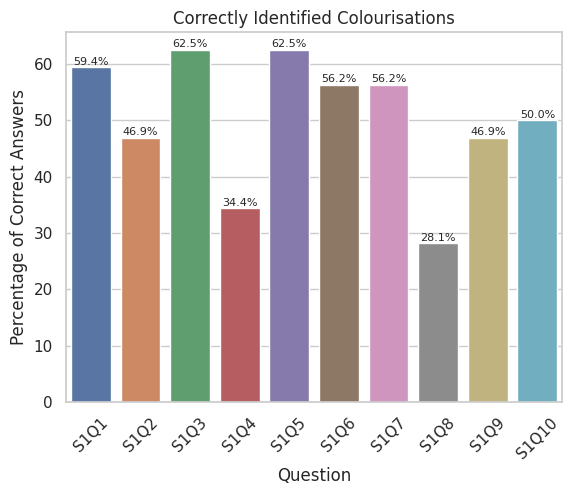

In [20]:
# Iterate over the dictionary items and calculate the percentage of correct answers for each column
percentages = {}
for column, answer in correct_answers.items():
    percentages[column] = (responses[column] == answer).mean() * 100
    
# Create a DataFrame from the percentages dictionary
df = pd.DataFrame.from_dict(percentages, orient='index', columns=['Percentage'])

# Reset the index and rename the column for better plot aesthetics
df = df.reset_index().rename(columns={'index': 'Question'})

# Plot the grouped bar plot using Seaborn
sns.set_style('whitegrid')
ax = sns.barplot(x='Question', y='Percentage', data=df)
plt.xlabel('Question')
plt.ylabel('Percentage of Correct Answers')
plt.title('Correctly Identified Colourisations')
plt.xticks(rotation=45)

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2, 
        height + .5,
        f'{height:.1f}%', 
        ha='center',
        fontsize=8
    )

plt.savefig('./results/gan/correct_col.png')
plt.show()

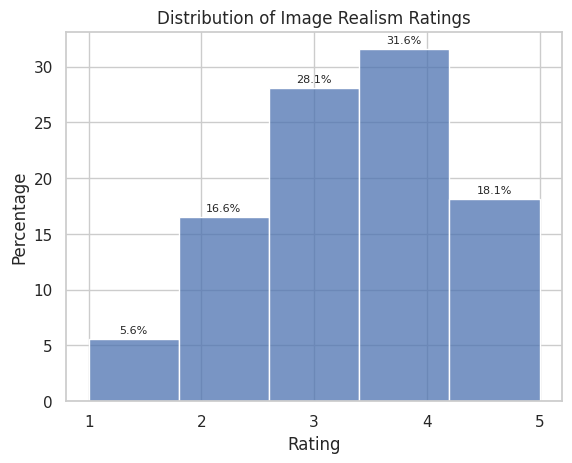

Average Rating: 3


In [57]:
import numpy as np

# Create a list of column names for the ratings
realism_questions = ['S2Q1', 'S2Q2', 'S2Q3', 'S2Q4', 'S2Q5', 'S2Q6', 'S2Q7', 'S2Q8', 'S2Q9', 'S2Q10']

# Extract the ratings from the responses dataframe
ratings = responses[realism_questions].values.ravel()

# Create the histogram
ax = sns.histplot(x=ratings, kde=False, stat='percent', bins=5)

# Set the axis labels and title
plt.xlabel('Rating')
plt.ylabel('Percentage')
plt.title('Distribution of Image Realism Ratings')
plt.xticks(np.arange(1, 6 ,1))

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2, 
        height + .5,
        f'{height:.1f}%', 
        ha='center',
        fontsize=8
    )

# Show the histogram
plt.savefig('./results/gan/ratings.png')
plt.show()

averate_rating = round(np.mean(ratings))
print(f'Average Rating: {averate_rating:.0f}')

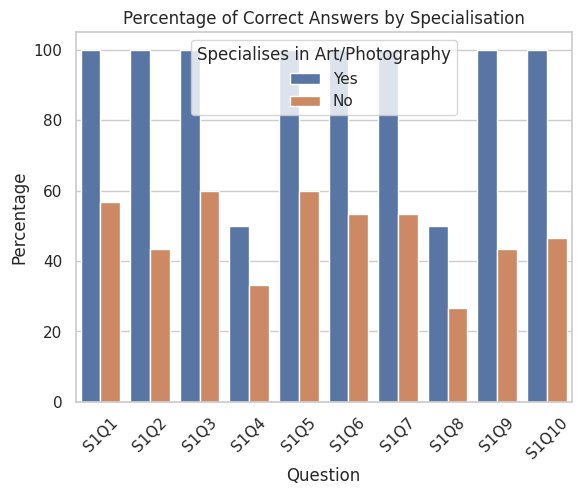

In [58]:
import numpy as np

specialise_yes = responses.loc[responses['specialise'] == 'Yes']
specialise_no = responses.loc[responses['specialise'] == 'No']

# Calculate the percentages for 'Yes' and 'No' specialisations
percentages_yes = [(specialise_yes[column] == answer).mean() * 100 for column, answer in correct_answers.items()]
percentages_no = [(specialise_no[column] == answer).mean() * 100 for column, answer in correct_answers.items()]

# Get the question labels for the x-axis
question_labels = list(correct_answers.keys())

# Create a DataFrame for the data
data = pd.DataFrame({
    'Question': question_labels,
    'Yes': percentages_yes,
    'No': percentages_no
})

# Reshape the data for plotting
data = data.melt(id_vars='Question', var_name='Specialises in Art/Photography', value_name='Percentage')

# Plot the bar graph using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Question', y='Percentage', hue='Specialises in Art/Photography', data=data)

# Add labels and title
plt.xlabel('Question')
plt.ylabel('Percentage')
plt.title('Percentage of Correct Answers by Specialisation')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.savefig('./results/gan/correct_spec.png')
plt.show()

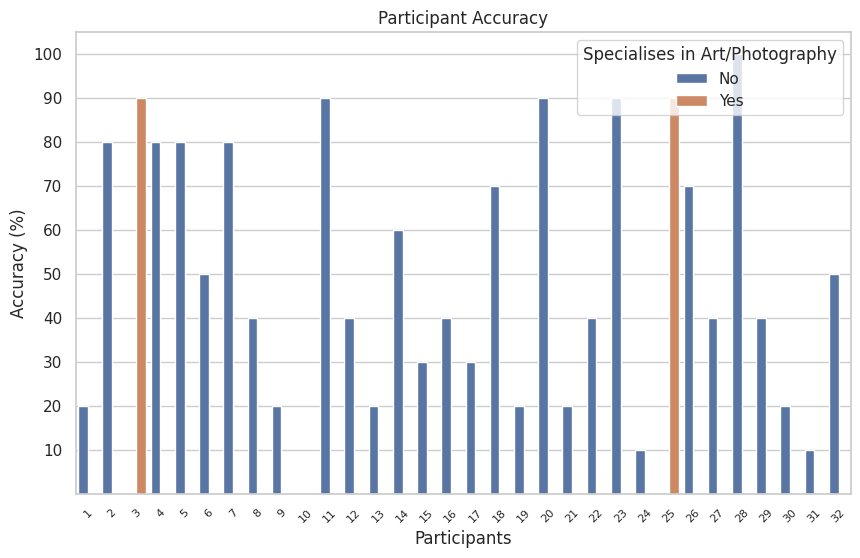

In [59]:
import numpy as np

questions = responses[correct_answers.keys()]
# Calculate the number of correct answers for each participant
accuracy = questions.eq(correct_answers).mean(axis=1) * 100

# Create a new data frame with Participant and Accuracy columns
participant_accuracy = pd.DataFrame({'Participant': responses.index + 1, 'Accuracy': accuracy, 'Specialise': responses['specialise']})
participant_accuracy.to_csv('../survey/ae/participant_answers.csv', index=False)

# Plot the participant accuracy with specialised information using seaborn
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Participant', y='Accuracy', hue='Specialise', data=participant_accuracy)
ax.tick_params(axis='x', labelsize=8, rotation=45)
plt.xlabel('Participants')
plt.ylabel('Accuracy (%)')
plt.title('Participant Accuracy')
plt.legend(title='Specialises in Art/Photography', loc='upper right')
plt.yticks(np.arange(10, 110, 10))

plt.savefig('./results/gan/accuracy.png')
plt.show()